In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
from pathlib import Path
import random
import time
from typing import Any, Dict, List

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import tqdm
import wandb

from src.data.rnn_preprocessing import clean_company_name_string

# Добавляем путь к основной папке проекта, чтобы иметь возможность делать импорт из src
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
data = pd.read_csv('../data/raw/train.csv')
data.head()

,pair_id,name_1,name_2,is_duplicate
0,1,Iko Industries Ltd.,"Enormous Industrial Trade Pvt., Ltd.",0
1,2,Apcotex Industries Ltd.,Technocraft Industries (India) Ltd.,0
2,3,"Rishichem Distributors Pvt., Ltd.",Dsa,0
3,4,Powermax Rubber Factory,Co. One,0
4,5,Tress A/S,Longyou Industries Park Zhejiang,0


## 1. Разбиваем на train/test также, как Петр Корчагин (для сравнимости)

In [4]:
X = data.drop(['is_duplicate'], axis = 1)
y = data.is_duplicate

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state = 666,
    stratify = y,
    test_size = 0.2
)

X_train['is_duplicate'] = y_train
X_test['is_duplicate'] = y_test

## 2. Очистим названия компаний из train/test раздельно

In [5]:
# Очистим названия 

train_names = sorted(set(list(X_train['name_1'].values) + list(X_train['name_2'].values)))
clean_train_names = [clean_company_name_string(name) for name in train_names]

test_names = sorted(set(list(X_test['name_1'].values) + list(X_test['name_2'].values)))
clean_test_names = [clean_company_name_string(name) for name in test_names]

In [6]:
clean_train_characters = set()
for name in clean_train_names:
    clean_train_characters.update(name.lower())

#### Символы после очистки:

In [7]:
clean_train_characters

{' ',
 "'",
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z'}

#### остались только цифры, английский алфавит, проблем и "'" - апостроф - это последствия транслитерации с русского языка (пока оставим так)

In [8]:
print(f'Всего различных символов: {len(clean_train_characters)}')

Всего различных символов: 38


#### добавим pad symbol (0) и на всякий случай символ unknown (39)

In [9]:
num_symbols = len(clean_train_characters) + 2
print(f'Всего на вход NN будут подаваться векторы длиной {num_symbols}')

Всего на вход NN будут подаваться векторы длиной 40


# Разобьем кластеризованные данные о компаниях на train и valid

In [10]:
train_companies = pd.read_csv('../data/processed/X_train_companies_with_clusters.csv')
train_companies.head()

,name,cluster
0,Alfagomma,0
1,LANXESS Inc.,-1
2,Lanxess Accounting GmbH,-1
3,"Lanxess International Trading (Shanghai) Co.,...",-1
4,Lanxess Sas,-1


In [11]:
from sklearn.model_selection import GroupShuffleSplit 
from sklearn.model_selection import train_test_split

valid_share = 0.1

# Разбиваем часть датасета, где известны кластеры
train_companies_with_clusters = train_companies[train_companies['cluster'] != -1]
splitter = GroupShuffleSplit(test_size=valid_share, n_splits=1, random_state = 2205)
split = splitter.split(train_companies_with_clusters, groups=train_companies_with_clusters['cluster'])
train_inds, valid_inds = next(split)

train_with_clusters = train_companies_with_clusters.iloc[train_inds]
valid_with_clusters = train_companies_with_clusters.iloc[valid_inds]

# Разделяем часть датасета, где нет известных кластеров
train_companies_with_clusters = train_companies[train_companies['cluster'] == -1]
train_no_clusters, valid_no_clusters = train_test_split(
    train_companies_with_clusters,
    random_state = 2205,
    test_size = valid_share
)

In [12]:
train_data = pd.concat([train_with_clusters, train_no_clusters]).reset_index(drop=True)
valid_data = pd.concat([valid_with_clusters, valid_no_clusters]).reset_index(drop=True)

train_data.to_csv('../data/processed/train_companies_for_metric_learning.csv', index=False)
valid_data.to_csv('../data/processed/valid_companies_for_metric_learning.csv', index=False)

In [13]:
characters = [' ', "'", '0', '1', '2',
              '3', '4', '5', '6', '7',
              '8', '9', 'a', 'b', 'c',
              'd', 'e', 'f', 'g', 'h',
              'i', 'j', 'k', 'l', 'm',
              'n', 'o', 'p', 'q', 'r',
              's', 't', 'u', 'v', 'w',
              'x', 'y', 'z']
              
char_dict = {v: k + 1 for k, v in enumerate(characters)}

def encode_string(s: str, char_dict=char_dict) -> torch.LongTensor:
    n_chars = len(char_dict) + 2
    unknown = len(char_dict) + 1
    idxs = torch.LongTensor([char_dict.get(c, unknown) for c in s])
    return idxs

In [24]:
class LSTMNetwork(nn.Module):
    def __init__(self,
                 chars: Dict[str, int],
                 emb_dim: int = 20,
                 hidden_size = 100,
                 num_layers: int = 1,
                 dropout: float = 0.0):
        super(LSTMNetwork, self).__init__()
        self.chars = chars
        self.hidden_size = hidden_size
        self.emb = nn.Embedding(len(self.chars) + 2, emb_dim)
        self.LSTM = nn.LSTM(input_size=emb_dim,
                            hidden_size=self.hidden_size,
                            num_layers=num_layers,
                            bidirectional=True,
                            dropout=dropout)
        
    def emb_packed_sequence(self, packed_sequence):
        return torch.nn.utils.rnn.PackedSequence(self.emb(packed_sequence.data), packed_sequence.batch_sizes)
        
    def forward(self, x: List[str]):
        # Кодируем текст в соответствии со словарем символов
        encoded = [encode_string(el) for el in x]
        text_lengths = np.array([len(el) for el in x])
        
        # добавляем паддинг + упаковываем
        padded_encoded = torch.nn.utils.rnn.pad_sequence(encoded).to(device)
        packed_encoded = torch.nn.utils.rnn.pack_padded_sequence(padded_encoded, text_lengths)
        
        # пропускаем через слой с эмбеддингами и LSTM
        packed_emb = self.emb_packed_sequence(packed_encoded)
        packed_lstm_output, _ = self.LSTM(packed_emb)
        output, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_lstm_output)

        # собираем представление текста с учетом реальной длины исходного текста
        fwd_state = output[text_lengths - 1, range(len(text_lengths)), :self.hidden_size]
        rev_state = output[0, :, :self.hidden_size]
        output = torch.cat((fwd_state, rev_state), 1)
        
        return output

In [15]:
class CompanyNameDataLoader:
    ''' Класс с функционалом DataLoader'а - проходим по датасету с заданным размером батча, в каждом батче:
        - 1 опорный элемент
        - 1 элемент из того же кластера - positive
        - batch_size - 2 элемента из других классов - negative 
    '''
    def __init__(self, data, shuffle: bool = True, batch_size: int = 16, preprocessing: Any=None):
        self.data = data
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.preprocessing = preprocessing
        # Опорные items - проход будет заключаться в проходе по всем таким названиям
        self.basis_items = data[data['cluster'] != -1]['name'].values
        if self.shuffle:
            random.shuffle(self.basis_items)
        self.size = len(self.basis_items)
        
        # Подготовим кластеры для выбора positive items
        data_with_clusters = self.data[self.data['cluster'] != -1].reset_index(drop=True)
        clusters = defaultdict(list)
        for i, row in data_with_clusters.iterrows():
            clusters[row['cluster']].append(row['name'])
        self.clusters = clusters
        
        # Список негативных элементов
        random.seed(2205)
        self.negative = list(data[data['cluster'] == -1]['name'].values)
        random.shuffle(self.negative)
        random.seed()
        
    def __iter__(self):
        self.idx = 0
        self.negative_idx = 0
        return self
    
    def __next__(self):
        if self.idx == self.size:
            raise StopIteration
        item = self.basis_items[self.idx]
        cluster_id = self.data[self.data['name'] == item]['cluster'].iloc[0]
        cluster = self.clusters[cluster_id]
        positive_candidates = set(cluster) - set([item])
        if self.shuffle:
            positive_item = random.choice(tuple(positive_candidates))
        else:
            positive_item = sorted(positive_candidates)[-1]
        
        if self.shuffle:
            negative_items = random.sample(self.negative, self.batch_size - 2)
        else:
            negative_items = self.negative[self.negative_idx: self.negative_idx + self.batch_size - 2]
            self.negative_idx += self.batch_size - 2
            if self.negative_idx >= len(self.negative):
                self.negative_idx = 0
                
        self.idx += 1
        
        if self.preprocessing is not None:
            item = self.preprocessing(item)
            positive_item = self.preprocessing(positive_item)
            negative_items = [self.preprocessing(s) for s in negative_items]
            
        labels = list(range(self.batch_size))
        labels[0] = 1
        labels[1] = 1
        
        return [item, positive_item] + negative_items, labels

In [16]:
# dl = CompanyNameDataLoader(train_companies, shuffle=True, preprocessing=clean_company_name_string)
# a = iter(dl)
# next(a)

In [17]:
# batch = next(a)
# batch

In [18]:
from pytorch_metric_learning import losses
from pytorch_metric_learning.distances import CosineSimilarity

In [19]:
contrastive_loss = losses.ContrastiveLoss(pos_margin=1, neg_margin=0, distance=CosineSimilarity())

# Цикл обучения

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [21]:
output_path = Path('../models')

In [28]:
lr = 1e-3
emb_dim = 40
hidden_size = 40
num_layers = 3
dropout = 0.0
batch_size = 16
exp_name = f'LSTM_{emb_dim}_{hidden_size}_{num_layers}_{dropout}'

config = dict (
    learning_rate = lr,
    architecture = "LSTM",
    batch_size = batch_size,
    hidden_size = hidden_size,
    num_layers = num_layers
)

wandb.init(
  project='dl_cnp_23',
  name=exp_name,
  config=config,
)

train_dataloader = CompanyNameDataLoader(train_data, shuffle=True, preprocessing=clean_company_name_string)
valid_dataloader = CompanyNameDataLoader(valid_data, shuffle=False, preprocessing=clean_company_name_string)

net = LSTMNetwork(char_dict,
                  emb_dim=emb_dim,
                  hidden_size=hidden_size,
                  num_layers=num_layers,
                  dropout=dropout).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
best_valid_loss = np.inf

for epoch in range(20):
    print(f'Epoch {epoch}')
    train_losses = []
    for batch in tqdm.tqdm(train_dataloader):
        optimizer.zero_grad()
        pairs = zip(batch[0], batch[1])
        sorted_pair = sorted(pairs, key=lambda x: len(x[0]), reverse=True)
        x, y = zip(*sorted_pair)
        pred = net(x)
        loss = contrastive_loss(pred, torch.Tensor(y).to(device))
        loss.backward()
        train_losses.append(loss.item())
        optimizer.step()
    train_loss = np.mean(train_losses)
    time.sleep(0.5)
    valid_losses = []
    for batch in tqdm.tqdm(valid_dataloader):
        pairs = zip(batch[0], batch[1])
        sorted_pair = sorted(pairs, key=lambda x: len(x[0]), reverse=True)
        x, y = zip(*sorted_pair)
        with torch.no_grad():
            pred = net(x)
            loss = contrastive_loss(pred, torch.Tensor(y).to(device))
        valid_losses.append(loss.item())
    valid_loss = np.mean(valid_losses)
    print(f'train loss: {train_loss}, valid_loss: {valid_loss}')
    wandb.log({'train_loss': train_loss, 'valid_loss': valid_loss}, step=epoch)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(net.state_dict(), output_path / f'{exp_name}_best.pth')
    time.sleep(0.5)

wandb.finish()

Epoch 0


1096it [00:10, 100.79it/s]
107it [00:00, 317.05it/s]


train loss: 0.5308884315899689, valid_loss: 0.5270097484098417
Epoch 1


1096it [00:11, 99.25it/s] 
107it [00:00, 311.01it/s]


train loss: 0.29414310523845855, valid_loss: 0.5122157505878778
Epoch 2


1096it [00:11, 96.12it/s] 
107it [00:00, 311.21it/s]


train loss: 0.22428674812353874, valid_loss: 0.4014192855803766
Epoch 3


1096it [00:11, 98.49it/s] 
107it [00:00, 320.17it/s]


train loss: 0.18714261187893086, valid_loss: 0.39329589656162484
Epoch 4


1096it [00:11, 98.73it/s] 
107it [00:00, 313.21it/s]


train loss: 0.18001804794830673, valid_loss: 0.49608927825900995
Epoch 5


1096it [00:11, 97.21it/s] 
107it [00:00, 313.21it/s]


train loss: 0.16031318483024454, valid_loss: 0.4817408406149561
Epoch 6


1096it [00:10, 99.88it/s] 
107it [00:00, 322.60it/s]


train loss: 0.15732403023229627, valid_loss: 0.38552418034349645
Epoch 7


1096it [00:10, 100.78it/s]
107it [00:00, 327.20it/s]


train loss: 0.12790352348017295, valid_loss: 0.3927682923309714
Epoch 8


1096it [00:11, 98.28it/s] 
107it [00:00, 319.64it/s]


train loss: 0.12556557262479498, valid_loss: 0.44286485395838165
Epoch 9


1096it [00:11, 98.09it/s] 
107it [00:00, 309.62it/s]


train loss: 0.10366546592749927, valid_loss: 0.4254467750542632
Epoch 10


1096it [00:11, 98.26it/s] 
107it [00:00, 308.87it/s]


train loss: 0.10262215685016088, valid_loss: 0.38961039084906335
Epoch 11


1096it [00:11, 98.61it/s]
107it [00:00, 322.25it/s]


train loss: 0.11686395916639127, valid_loss: 0.44326475302680074
Epoch 12


1096it [00:11, 99.57it/s] 
107it [00:00, 308.25it/s]


train loss: 0.09977626546569013, valid_loss: 0.44531715434984626
Epoch 13


1096it [00:11, 98.13it/s] 
107it [00:00, 333.31it/s]


train loss: 0.09479303800723562, valid_loss: 0.44742063061273263
Epoch 14


1096it [00:12, 90.62it/s]
107it [00:00, 303.70it/s]


train loss: 0.08867561188420234, valid_loss: 0.4161823017818627
Epoch 15


1096it [00:11, 93.90it/s] 
107it [00:00, 312.50it/s]


train loss: 0.10002381237645219, valid_loss: 0.4575121718824397
Epoch 16


1096it [00:11, 98.44it/s] 
107it [00:00, 312.47it/s]


train loss: 0.08641769288992127, valid_loss: 0.49630803576557436
Epoch 17


1096it [00:11, 98.91it/s]
107it [00:00, 306.00it/s]


train loss: 0.08172067855042915, valid_loss: 0.5118013442489623
Epoch 18


1096it [00:11, 98.60it/s] 
107it [00:00, 312.27it/s]


train loss: 0.08028510792053858, valid_loss: 0.4870257266301
Epoch 19


1096it [00:11, 99.13it/s] 
107it [00:00, 314.21it/s]


train loss: 0.08256626238183537, valid_loss: 0.45060287322849035


train_loss,█▄▃▃▃▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁
valid_loss,█▇▂▁▆▆▁▁▄▃▁▄▄▄▃▅▆▇▆▄
train_loss,0.08257
valid_loss,0.4506


In [55]:
net = LSTMNetwork(char_dict,
                  emb_dim=40,
                  hidden_size=60,
                  num_layers=3,
                  dropout=0.0).to(device)
net.load_state_dict(torch.load('../models/LSTM_40_60_3_0.0_best.pth'))
net.eval()

LSTMNetwork(
  (emb): Embedding(40, 40)
  (LSTM): LSTM(40, 60, num_layers=3, bidirectional=True)
)

In [56]:
def get_similarity_stats_within_clusters(model, data, preprocessing=clean_company_name_string):
    cluster_data = data[data['cluster'] != -1].reset_index(drop=True)
    similarity = CosineSimilarity()
    cluster_similarity = []
    for cluster_id in cluster_data['cluster'].unique():
        cluster = cluster_data[cluster_data['cluster'] == cluster_id]
        names = list(cluster['name'].values)
        clean_names = [preprocessing(name) for name in names]
        clean_names = sorted(clean_names, key=lambda x: len(x), reverse=True)
        with torch.no_grad():
            pred = net(clean_names)
        similarity_result = similarity(pred).cpu().numpy()
        n = len(clean_names)
        current_similarity = (similarity_result.sum() - n) / (n ** 2 - n)
        cluster_similarity.append(current_similarity.mean())
    return cluster_similarity

def get_similarity_stats_between_clusters(model, data, preprocessing=clean_company_name_string):
    cluster_data = data[data['cluster'] != -1].reset_index(drop=True)
    similarity = CosineSimilarity()
    cluster_similarity = []
    for cluster_id in cluster_data['cluster'].unique():
        cluster = cluster_data[cluster_data['cluster'] == cluster_id]
        names = list(cluster['name'].values)
        other_names = list(data[data['cluster'] == -1]['name'].values)
        all_names = names + other_names
        
        clean_names = [preprocessing(name) for name in all_names]
        clean_names = sorted(clean_names, key=lambda x: len(x), reverse=True)
        with torch.no_grad():
            pred = net(clean_names)
        
        similarity_result = similarity(pred).cpu().numpy()
        n = len(clean_names)
        current_similarity = similarity_result[: n].flatten()
        current_similarity = (current_similarity.sum() - len(names)) / (len(current_similarity) - len(names))
        cluster_similarity.append(current_similarity)
    return cluster_similarity

In [57]:
similarity_within_clusters = get_similarity_stats_within_clusters(net, valid_data)
similarity_between_clusters = get_similarity_stats_between_clusters(net, valid_data)

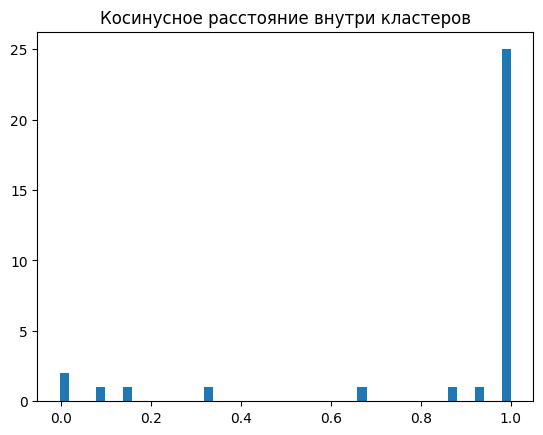

In [58]:
plt.hist(similarity_within_clusters, bins=50)
plt.title('Косинусное расстояние внутри кластеров')
plt.show()

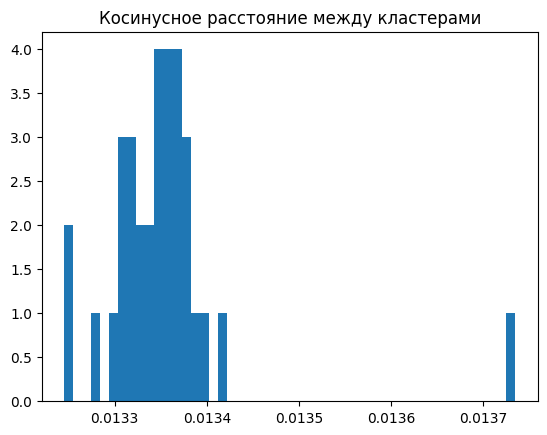

In [59]:
plt.hist(similarity_between_clusters, bins=50)
plt.title('Косинусное расстояние между кластерами')
plt.show()

# Рассчитаем метрики на test (классификация)

In [61]:
test = pd.read_csv('../data/interim/X_test.csv')

In [62]:
similarity = CosineSimilarity()

prediction = []
for i, row in tqdm.tqdm(test.iterrows()):
    names = [row['name_1'], row['name_2']]
    clean_names = [clean_company_name_string(name) for name in names]
    clean_names = sorted(clean_names, key=lambda x: len(x), reverse=True)
    if len(clean_names[0]) == 0 or len(clean_names[1]) == 0:
        prediction.append(0)
        continue
    with torch.no_grad():
        pred = net(clean_names)
    distance = similarity(pred).cpu().numpy()[0, 1]
    prediction.append(distance)

99564it [02:09, 770.51it/s]


In [90]:
test['distance'] = prediction
test['pred'] = test['distance'] > 0.9999

In [91]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [92]:
precision_score(test['is_duplicate'], test['pred'])

0.2991150442477876

In [93]:
recall_score(test['is_duplicate'], test['pred'])

0.6926229508196722

In [94]:
f1_score(test['is_duplicate'], test['pred'])

0.41779975278121134

In [95]:
test[(test['distance'] == 1) & (test['is_duplicate'] == 0)]

,pair_id,name_1,name_2,is_duplicate,distance,pred
804,477222,Breakthru Beverage Maryland,Breakthru Beverage De,0,1.0,True
1213,294391,Bank Asia Ltd.,Bank Of America,0,1.0,True
1515,29236,Ansell Healthcare,Ansell Lanka (Pvt) Ltd.,0,1.0,True
5473,212457,American Roll Sa De Cv,American Cashew Co.,0,1.0,True
11777,2994,Comercial Conte S.A.C.,Comercial Duomo Ltda,0,1.0,True
12937,60508,Inversiones Bogantes Y Corella Sociedad Anonima,Inversionistas Y Distribuidores Sociedad Anoni...,0,1.0,True
19316,161882,Binex Line Corp. Hq (Csr),Binex Line Corp.,0,1.0,True
24467,401728,American Roll Sa De Cv,American Precision Assemblers De Mexico S. De ...,0,1.0,True
27566,425177,Comercializadora Marsolu Sa De Cv,Comercializadora Llantas Unidas International ...,0,1.0,True
28629,457930,Jas Forwarding World Wide Inc.,Jas Forwarding (Usa) Inc.,0,1.0,True


In [97]:
test[(test['is_duplicate'] == 0) & test['pred']].head(50)

,pair_id,name_1,name_2,is_duplicate,distance,pred
53,365945,Summary Ag,Summa Sistemas C. A,0,0.999993,True
121,117099,Anurun Trading,Arabian Darb General Trading And,0,0.999952,True
269,266226,Al Basir Trading Co.,Al Huda Shoes Trading,0,0.999985,True
292,487753,Industrial Organics (Pty) Ltd.,Industrias Tuk S.A. De C.V.,0,0.999982,True
327,85479,Zhejiang Materials Industry Chemical Group Co....,Zhejiang Mingri Holdings,0,0.999995,True
337,40595,Al Tec International,Alex Extrusions Ltd.,0,0.999999,True
367,294648,To The Order Of,To Order Notify:Africa Agri Tech,0,0.999937,True
449,273778,Commander Logistica Ltda,"Commerce Logistics (Shanghai) Co., Ltd.",0,0.999986,True
492,118451,"Alaska Rubbers Pvt., Ltd.","Anand Chemicals & Rubber Pvt., Ltd.",0,0.999995,True
570,137967,Dresco,Dls Comercial E.I.R.L,0,0.999989,True
